In [3]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mental_health_subreddits_dataset.csv')

In [41]:
df.tail()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
45879,17777050,anxiety,1581473713,"It is quite interesting, in terms of somewhat ...",-0.9256
45880,17777094,anxiety,1581466598,Stay focused on what the experts are saying an...,0.7430
45881,17777113,anxiety,1581463547,"No new COVID-19 cases in B.C., 4 confirmed pat...",-0.1531
45882,17777197,mentalhealth,1581454025,"Hi mate, as someone with GAD I can relate to y...",0.5332
45883,17777368,anxiety,1581071322,***MORE UPDATES ON MY OTHER COMMENT ON THIS T...,0.9325


In [6]:
sample = df.sample(20000)
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
41102,16344388,anxiety,1588003340,Anyone concerned about inflation because of th...,0.0000
31025,13599101,suicidewatch,1596945584,Depression and addictive personalities run in ...,-0.8074
14346,7803673,suicidewatch,1613659303,First off you do music so you’re obviously coo...,0.9295
22805,10987330,anxiety,1604980834,No medication. I've barely done exercise and h...,-0.7351
25399,11933425,anxiety,1602165803,Your post has **not** been removed or flagged....,0.7635


In [7]:
count = Counter()
for index, row in sample.iterrows():
    if row['subreddit.name'] == 'anxiety':
        count['anxiety'] += 1
    if row['subreddit.name'] == 'depression':
        count['depression'] += 1
    if row['subreddit.name'] == 'suicidewatch':
        count['SuicideWatch'] += 1
    if row['subreddit.name'] == 'mentalhealth':
        count['mentalhealth'] += 1
    if row['subreddit.name'] == 'covid19_support':
        count['COVID19_support'] += 1
count

Counter({'anxiety': 7290,
         'SuicideWatch': 1768,
         'depression': 2591,
         'COVID19_support': 6903,
         'mentalhealth': 1448})

## Preprocessing 

In [8]:
import re #regex library used for substituting words

In [9]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [11]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [12]:
sample.body = sample.body.apply(lambda x: preprocessing(x))

In [13]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
41102,16344388,anxiety,1588003340,anyone concerned inflation covid thing,0.0000
31025,13599101,suicidewatch,1596945584,depression addictive personalities run sides f...,-0.8074
14346,7803673,suicidewatch,1613659303,first music obviously cool second sorry going ...,0.9295
22805,10987330,anxiety,1604980834,medication barely done exercise rubbish diet s...,-0.7351
25399,11933425,anxiety,1602165803,post removed flagged see mentioned covid pleas...,0.7635


In [14]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
    else:
        sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

Text(0.5, 1.0, 'Sentiment Data Distribution')

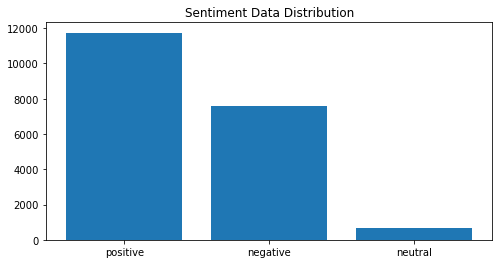

In [15]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [39]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16773,8785745,anxiety,1610719216,post holiday surge alberta covid numbers appea...,positive
39995,16078481,anxiety,1588907924,thinking thing turns created founders instagra...,positive
9436,5538126,anxiety,1620672106,exactly know linked anxiety days feel bit bett...,negative
11522,6580945,covid19_support,1617612469,sure else think unfair whatever hell wants eve...,negative
38230,15581819,depression,1590680704,yea feel helplessness trying get cycle sucks c...,positive


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16000
Test Data size 4000


## Vectorizing

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [20]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (16000, 8855)
x_test Shape: (4000, 8855)


In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (16000, 1)
y_test shape: (4000, 1)


## Linear SVM Model

In [89]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics

In [24]:
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = classifier_linear.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0, 2.0]
target_names = ['negative', 'neutral', 'positive']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 63.251653s; Prediction time: 12.819747s
Accuracy: 0.7905
positive:  {'precision': 0.8199186991869919, 'recall': 0.860494880546075, 'f1-score': 0.8397169025811824, 'support': 2344}
negative:  {'precision': 0.7435897435897436, 'recall': 0.7450592885375494, 'f1-score': 0.7443237907206319, 'support': 1518}
neutral:  {'precision': 0.7368421052631579, 'recall': 0.10144927536231885, 'f1-score': 0.17834394904458598, 'support': 138}


## Feature Importance

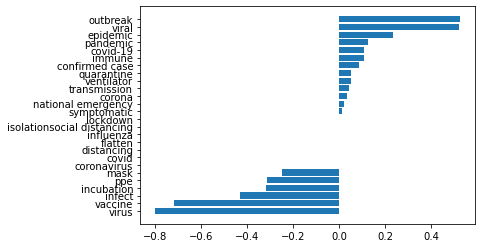

In [25]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['corona', 
                  'virus', 
                  'viral', 
                  'covid', 
                  'influenza', 
                  'pandemic', 
                  'epidemic', 
                  'quarantine', 
                  'lockdown',
                  'distancing', 
                  'national emergency', 
                  'flatten', 
                  'infect', 
                  'ventilator', 
                  'mask', 
                  'symptomatic', 
                  'immune', 
                  'incubation', 
                  'transmission', 
                  'vaccine',
                  'confirmed case',
                  'coronavirus',
                  'covid-19',
                  'outbreak',
                  'ppe',
                  'isolation'
                  'social distancing' ]
f_importances(classifier_linear.coef_.toarray()[0], features_names)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

26656


/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


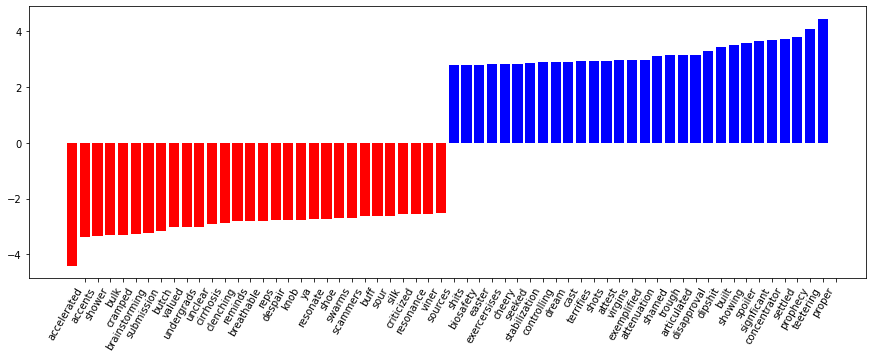

In [27]:
def plot_coefficients(classifier, feature_names, top_features=30):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
cv = CountVectorizer(stop_words = 'english')
cv.fit(train_data.body.to_list())
print (len(cv.vocabulary_))

svm = LinearSVC()
svm.fit(x_train, y_train)

plot_coefficients(svm, cv.get_feature_names())